# Sprint 3

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from fastai.vision.all import PILImage
import matplotlib.pyplot as plt

2022-12-22 09:11:53.328672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 09:11:53.729778: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-22 09:11:55.058855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-22 09:11:55.058996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

## Checking if gpu is available

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3971546288231065025
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10910760960
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 11866661542868266544
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:b0:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-12-22 09:12:00.935320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 09:12:02.218620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 10405 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:b0:00.0, compute capability: 6.1


Loading dataset

In [3]:
# (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train_full = X_train_full.astype(np.float32) / 255
# X_test = X_test.astype(np.float32) / 255
# X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
# y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

IMG_HEIGHT = 128
IMG_WIDTH = 128
img_folder = "../tripadvisor_dataset/tripadvisor_images_small"

def create_dataset(img_folder, n=None):
    # n = amount of images
    image_files=os.listdir(os.path.join(img_folder))
    if n==None:
        n=len(image_files)
    images = np.zeros((n, IMG_HEIGHT, IMG_WIDTH, 3))
    for i,file in enumerate(image_files[:n]):
        # print(f"{i},{file}")
        img=PILImage.create(os.path.join(img_folder,file))
        img_resized=img.resize((IMG_HEIGHT,IMG_WIDTH))
        img_np = np.array(img_resized) #.reshape((IMG_HEIGHT,IMG_WIDTH, 3)) #.astype(np.float32)
        images[i]=img_np/255
    return images

images = create_dataset(img_folder)
images_length = len(images)
X_train_full = images
X_train_full.shape

(15182, 128, 128, 3)

In [4]:
model = keras.models.load_model("../results")
results = model.predict(X_train_full)

indices = np.argwhere(results < 0.5)
indices = indices[..., 0]
test = X_train_full
X_train_full = X_train_full[indices]
X_train_full.shape

2022-12-22 09:13:17.544655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:b0:00.0, compute capability: 6.1
2022-12-22 09:13:36.414850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


475/475 [==============================] - 14s 24ms/step


(10886, 128, 128, 3)

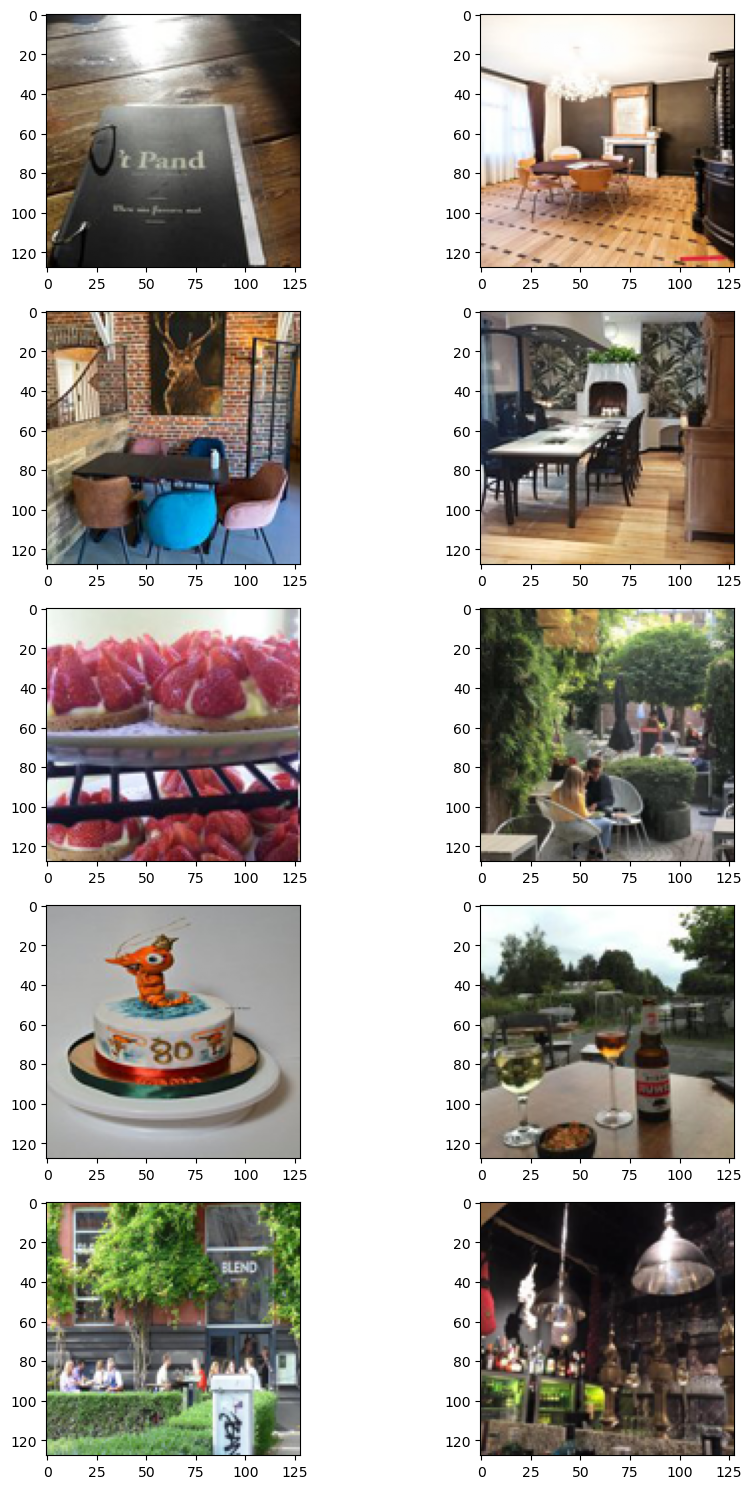

In [5]:
indices_buildings = np.argwhere(results >= 0.5)
indices_buildings = indices_buildings[..., 0]
buildings = test[indices_buildings]

fig=plt.figure(figsize=(10,15))
for i in range(0,10):
    plt.subplot(5,2,i+1)
    img = buildings[i]
    # restaurant name get be obtained in file_names[i]
    plt.imshow(img)
fig.tight_layout()
plt.show()


Splitting the dataset in test and validation

In [6]:
from sklearn.model_selection import train_test_split

positie = len(X_train_full) - 5
test_set = X_train_full[positie:len(X_train_full)]
X_train_full = X_train_full[:positie]

print(test_set.shape)
print(X_train_full.shape)


(5, 128, 128, 3)
(10881, 128, 128, 3)


In [7]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


conv_encoder = keras.models.Sequential([
    # keras.layers.Reshape([128, 128, 3], input_shape=[128, 128, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"), 
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="selu", input_shape=[16, 16, 128]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])


conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train_full, X_train_full, epochs=10, validation_split=0.2)

# print(conv_encoder.summary())
# conv_decoder.summary()




Epoch 1/10
272/272 [==============================] - 16s 48ms/step - loss: 0.5767 - rounded_accuracy: 0.8325 - val_loss: 0.5447 - val_rounded_accuracy: 0.8937
Epoch 2/10
272/272 [==============================] - 10s 35ms/step - loss: 0.5409 - rounded_accuracy: 0.8986 - val_loss: 0.5403 - val_rounded_accuracy: 0.9028
Epoch 3/10
272/272 [==============================] - 10s 36ms/step - loss: 0.5366 - rounded_accuracy: 0.9060 - val_loss: 0.5368 - val_rounded_accuracy: 0.9058
Epoch 4/10
272/272 [==============================] - 10s 36ms/step - loss: 0.5344 - rounded_accuracy: 0.9099 - val_loss: 0.5325 - val_rounded_accuracy: 0.9176
Epoch 5/10
272/272 [==============================] - 9s 34ms/step - loss: 0.5323 - rounded_accuracy: 0.9143 - val_loss: 0.5327 - val_rounded_accuracy: 0.9167
Epoch 6/10
272/272 [==============================] - 10s 36ms/step - loss: 0.5311 - rounded_accuracy: 0.9166 - val_loss: 0.5387 - val_rounded_accuracy: 0.9064
Epoch 7/10
272/272 [=====================

Plotting training and loss curve

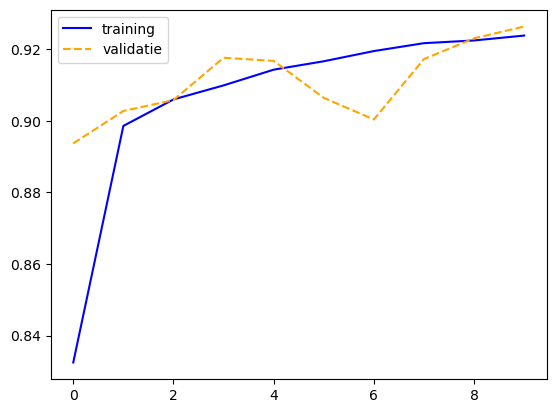

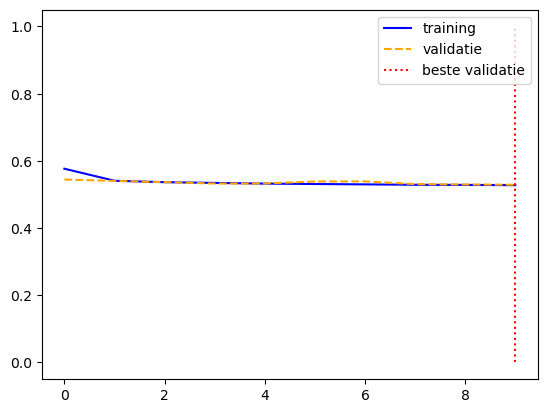

In [8]:
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
best_val_idx = np.argmin(val_loss_values)
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.vlines(x=best_val_idx, ymin=0, ymax=1, label='beste validatie', color='red', ls=':')
plt.legend()
plt.figure(0)
train_loss_values = history.history['rounded_accuracy']
val_loss_values = history.history['val_rounded_accuracy']
num_epochs = range(len(train_loss_values))

plt.plot(num_epochs, train_loss_values, label='training', color='blue', ls='-')
plt.plot(num_epochs, val_loss_values, label='validatie', color='orange', ls='--')
plt.legend()
plt.figure(1)
plt.show()

1/1 [==============================] - 0s 233ms/step


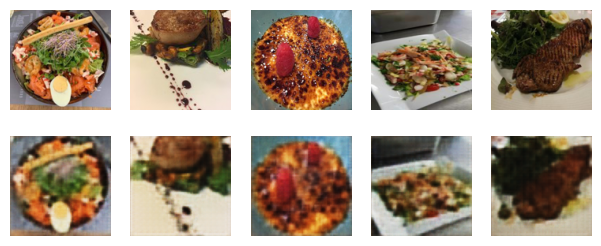

In [9]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


def show_reconstructions(model, images=test_set, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


show_reconstructions(conv_ae)

plt.show()


In [10]:
X_train_full[:1].shape

(1, 128, 128, 3)

## Save model

In [11]:
conv_encoder.save('./model_last_version/')

INFO:tensorflow:Assets written to: ./model_last_version/assets


INFO:tensorflow:Assets written to: ./model_last_version/assets


## getting features from encoder part

In [12]:
features = conv_encoder.predict(X_train_full)

341/341 [==============================] - 3s 9ms/step


In [13]:
# np.savetxt("features_encoder_pictures_with_no_buildings.txt", features)
import pickle
with open('features_encoder_pictures_with_no_buildings_last_version.pkl','wb') as f:
    pickle.dump(features, f)